In [2]:
# import Pkg; Pkg.develop(path="/Users/evanheberlein/Library/CloudStorage/Box-Box/Cornell/IRQIV.jl")
using IRQIV
import PyPlot as plt
import Statistics, NaNStatistics
plt.pygui(true) # sets plots to popup instead of inline

true

1.0%┣▍                                         ┫ 1/100 [00:07<Inf:Inf, InfGs/it]
9.0%┣████▎                                          ┫ 9/100 [00:10<01:50, 1s/it]
17.0%┣███████▋                                     ┫ 17/100 [00:11<00:56, 1it/s]
21.0%┣█████████▌                                   ┫ 21/100 [00:11<00:44, 2it/s]
24.0%┣██████████▉                                  ┫ 24/100 [00:11<00:37, 2it/s]
25.0%┣███████████▎                                 ┫ 25/100 [00:12<00:37, 2it/s]
27.0%┣████████████▏                                ┫ 27/100 [00:12<00:34, 2it/s]
30.0%┣█████████████▌                               ┫ 30/100 [00:12<00:30, 2it/s]
31.0%┣██████████████                               ┫ 31/100 [00:12<00:29, 2it/s]
32.0%┣██████████████▍                              ┫ 32/100 [00:13<00:28, 2it/s]
33.0%┣██████████████▉                              ┫ 33/100 [00:14<00:28, 2it/s]
40.0%┣██████████████████                           ┫ 40/100 [00:14<00:22, 3it/s]
41.0%┣██████████████████▌   

Performance stats (MQD loop only)
time [s]                    24.436521708
subwins/s              319.1943637971375
allocations [GB]                   13.44
allocations [MB/subwin]              172.29
time [m]                            0.41
total n subwindows                  7800
n image pairs                        100
n subwindows in FOV                   78
size(subwindows)                 (6, 13)
M, N                            (80, 80)
rhoI, rhoJ                      (80, 80)
allocations [B]              13438462736
allocations [MB]                13438.46
gc time [s]                  2.623437336
gc stats            Base.GC_Diff(13438462736, 39427, 1, 7631668, 6366, 38844, 2623437336, 13, 0)
number of threads                      8
Running on apple-m1 CPU specs:
Apple M1: 
       speed         user         nice          sys         idle          irq
#1  2400 MHz    1410166 s          0 s    1561031 s    7624329 s          0 s
#2  2400 MHz    1308089 s          0 s    1458604 s  

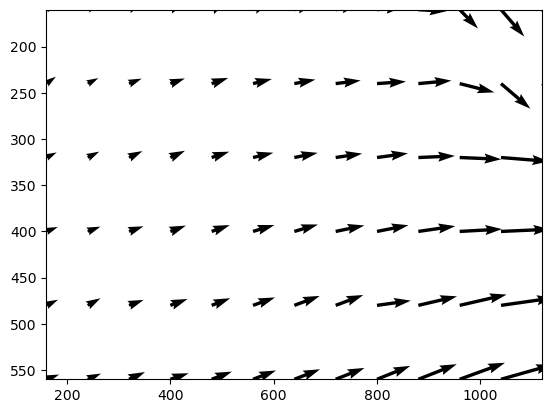

In [3]:
#### STREAMLINE METHOD 2 - MQD VECTOR FIELD

# Modifying downstream IRQIV code for same file as variance image

# Subwindow dimensions remain constant
const M=80 # subwindow dims - horiz, N = vert.
const N=80
const rhoI = 80 # how far away to search (+/-) - i=short side, j= long side
const rhoJ = 80 # Set these to visual estimates - plot one pair
MQD_parameters = (M=M, N=N, rhoI=rhoI, rhoJ=rhoJ)

# Set ATS parameters
Img_dims = [784, 1344] # Image dims: 784 x 1344
DtFrames = 1                    # Δt, frames (ATS 3116 is at 10Hz)
data_output_rate_frames = 1    # difference between I1 sequence, frames - time sep of output
nImagePairs = 100 # can set to inf - all frames in file
Nfiles = 40 # Set number of files to average over

# Load IR images:
I1inds = range(1, step=data_output_rate_frames, length=nImagePairs)
I2inds = I1inds .+ DtFrames

subwincorners = CartesianIndices(( (N+rhoI):N:(Img_dims[1]-(N+rhoI+1)), 
                                    (M+rhoJ):M:(Img_dims[2]-(M+rhoJ+1))))

filenum = 3504
FLIR_filename = joinpath("/Volumes/ETH_4TB/CNRD_IR/Rec-DeFreesLab_-00" * string.(filenum) * ".ats")
ats_year = 2022
@assert isfile(FLIR_filename)
I1images = LoadATSImageSequence(FLIR_filename, I1inds, ats_year)
I2images = LoadATSImageSequence(FLIR_filename, I2inds, ats_year)

# Remove image pairs when at least one image took place during NUC (calibration)
# mode:
if any(isnuc(I1images.Headers)) || any(isnuc(I2images.Headers))
    nuc_frames = isnuc(I1images.Headers) .| isnuc(I2images.Headers)
    I1inds = I1inds[.!( isnuc(I1images.Headers) .| isnuc(I2images.Headers) )]
    I2inds = I2inds[.!( isnuc(I1images.Headers) .| isnuc(I2images.Headers) )]
    I1images = LoadATSImageSequence(FLIR_filename, I1inds, ats_year)
    I2images = LoadATSImageSequence(FLIR_filename, I2inds, ats_year)
end

# Initialize MQD calculation:
MQD_variables = initialize_MQD(I1images,
                            I2images,
                            subwincorners,
                            N, M,
                            rhoI, rhoJ)                              

# Perform the MQD analysis:
subpix_shifts_i, subpix_shifts_j, performance_message = perform_MQD(
    I1images, I2images, subwincorners, MQD_variables)

# Plotting in pixel space (generate indices for vector locations) - issue w/ CSV package in multithread mode
x_vector = [index[2] for index in subwincorners]
y_vector = [index[1] for index in subwincorners]

plt.close("all")
fig,axs = plt.subplots()
strm = axs.streamplot(x_vector, y_vector, subpix_shifts_j[:,:,1], subpix_shifts_i[:,:,1], start_points = [(1120, 160)])
axs.quiver(x_vector, y_vector, subpix_shifts_j[:,:,1], subpix_shifts_i[:,:,1], angles="xy")
axs.invert_yaxis()
plt.gcf()



Dimensions of i: 6
Dimensions of j: 13
Dimensions of U: (6, 13)
Dimensions of V: (6, 13)
[160.0 450.0; 161.8112079071258 449.4729117742668; 179.9697590304095 444.4403754131109; 265.05980621589686 425.94271439764526; 328.06395318055917 412.2733610862107; 409.6128624700594 394.3379339198215; 503.6645504698251 372.67712536547094; 623.9622563315247 344.55677318605973; 888.6837747799814 290.44972365906654; 888.6837747799814 290.44972365906654][160.0 550.0; 162.04918804463796 549.5039432626531; 182.63480370809654 544.7598094305158; 292.79153295128435 525.0200397444919; 390.51253358749204 507.6735704894758; 530.4539845383632 478.8917963699761; 694.4588221711002 437.68354666297915; 987.8721525733481 364.76604953536054; 987.8721525733481 364.76604953536054]Streamline 1 has 10 coordinates.
Streamline 2 has 9 coordinates.


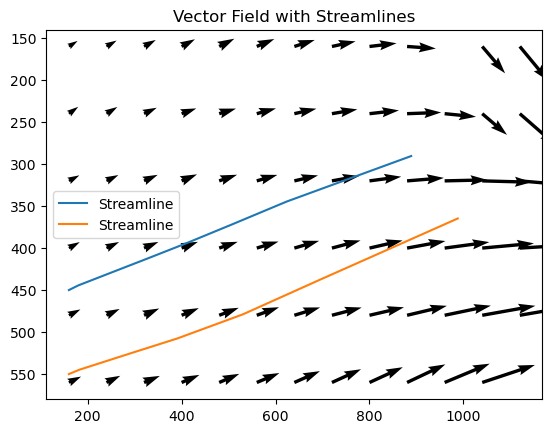

In [4]:
# Fit streamlines to vector field

import DifferentialEquations
using Interpolations
import StaticArrays

function meshgrid(x::AbstractVector, y::AbstractVector)
    X = repeat(x', length(y), 1)
    Y = repeat(y, 1, length(x))
    return X, Y
end

# Ensure data is in Float64 format
i = Float64[y_vector[:,1]...]
j = Float64[x_vector[1,:]...]
U = float.(dropdims(Statistics.mean(subpix_shifts_j, dims = 3), dims = 3))
V = float.(dropdims(Statistics.mean(subpix_shifts_i, dims = 3), dims = 3))

# Check dimensions
println("Dimensions of i: ", length(i))
println("Dimensions of j: ", length(j))
println("Dimensions of U: ", size(U))
println("Dimensions of V: ", size(V))

# Create linear interpolants for the vector field
u_interp = extrapolate(interpolate((i, j), U, Gridded(Linear())), Line())
v_interp = extrapolate(interpolate((i, j), V, Gridded(Linear())), Line())

function vector_field(u, p, t)
    x, y = u
    U = u_interp(x, y)
    V = v_interp(x, y)
    return StaticArrays.SA[U, V]
end

# Define initial conditions and time span
initial_conditions = [(160, 450), (160, 550)]
initial_conditions = [StaticArrays.SA[sp[1], sp[2]] for sp in initial_conditions]

# Store coordinates of all streamlines
all_streamline_coords = []

# Termination condition function
function terminate_at_bounds(u, t, integrator)
    y, x = u[1], u[2] # y = row, x = col. Changed this from ChatGPT code (x, y and it fixed bounds issue)
    # Check if x or y are outside the bounds defined by Img_dims
    return x < 1 || x > Img_dims[2] || y < 1 || y > Img_dims[1]
end

# Termination action function
function terminate_action!(integrator)
    DifferentialEquations.terminate!(integrator)
end

# Compute streamline function
function compute_streamline(start_point)
    # Convert the start point to a StaticArray
    start_point_sa = StaticArrays.SA[start_point[1], start_point[2]]

    # Set time span for the ODE solver
    tspan = (0.0, 200.0)  # Adjust the time span as needed

    # Create the DiscreteCallback
    cb = DifferentialEquations.DiscreteCallback(terminate_at_bounds, terminate_action!)

    # Define the ODEProblem with the initial condition and vector field
    prob = DifferentialEquations.ODEProblem(vector_field, start_point_sa, tspan)

    # Solve the ODEProblem with the callback
    sol = DifferentialEquations.solve(prob, DifferentialEquations.Tsit5(), callback=cb)

    # Extract and return the streamline coordinates
    streamline_coords = hcat(sol.u...)'
    # return streamline_coords
    coords = [(sol[1, i], sol[2, i]) for i in 1:length(sol.t)]
    push!(all_streamline_coords, coords)
    print(streamline_coords)
end

# Compute streamlines for all starting points
for sp in initial_conditions
    compute_streamline(sp)
end

# Plot the vector field using quiver
X, Y = meshgrid(j, i)

fig, ax = plt.subplots()
ax.quiver(X, Y, U, V, angles="xy") # Why the ' on U and V?

# Plot all streamlines
for coords in all_streamline_coords
    x_coords = [coord[1] for coord in coords]
    y_coords = [coord[2] for coord in coords]
    ax.plot(x_coords, y_coords, label="Streamline")
end

# Set labels and title
ax.invert_yaxis()  # To match the coordinate system of the matrices
ax.set_title("Vector Field with Streamlines")
ax.legend()

# Print the number of coordinates for each streamline
for (i, coords) in enumerate(all_streamline_coords)
    println("Streamline ", i, " has ", length(coords), " coordinates.")
end

# Show the plot
plt.gcf()

In [5]:
# Function definitions - line identification

# Define the meshgrid function
function meshgrid(x::AbstractVector, y::AbstractVector)
    X = repeat(x', length(y), 1)
    Y = repeat(y, 1, length(x))
    return X, Y
end

# Bresenham's line algorithm to get pixels for a line
function bresenham_line(x0, y0, x1, y1)
    pixels = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = x0 < x1 ? 1 : -1
    sy = y0 < y1 ? 1 : -1
    err = dx - dy

    while true
        push!(pixels, (x0, y0))
        if x0 == x1 && y0 == y1
            break
        end
        e2 = 2 * err
        if e2 > -dy
            err -= dy
            x0 += sx
        end
        if e2 < dx
            err += dx
            y0 += sy
        end
    end
    return pixels
end

# Wu's antialiasing algorithm - returns a raster along line w/ varying pixel intensities (smoothing effect)
function wu_line(x0, y0, x1, y1)
    function plot(x, y, c)
        return (x, y, c)
    end

    function ipart(x)
        return floor(Int, x)
    end

    function round(x)
        return ipart(x + 0.5)
    end

    function fpart(x)
        return x - floor(x)
    end

    function rfpart(x)
        return 1 - fpart(x)
    end

    steep = abs(y1 - y0) > abs(x1 - x0)

    if steep
        x0, y0 = y0, x0
        x1, y1 = y1, x1
    end

    if x0 > x1
        x0, x1 = x1, x0
        y0, y1 = y1, y0
    end

    dx = x1 - x0
    dy = y1 - y0
    gradient = dy / dx

    xend = round(x0)
    yend = y0 + gradient * (xend - x0)
    xgap = rfpart(x0 + 0.5)
    xpxl1 = xend
    ypxl1 = ipart(yend)
    pixels = [
        plot(xpxl1, ypxl1, rfpart(yend) * xgap),
        plot(xpxl1, ypxl1 + 1, fpart(yend) * xgap)
    ]

    intery = yend + gradient

    xend = round(x1)
    yend = y1 + gradient * (xend - x1)
    xgap = fpart(x1 + 0.5)
    xpxl2 = xend
    ypxl2 = ipart(yend)
    push!(pixels, plot(xpxl2, ypxl2, rfpart(yend) * xgap))
    push!(pixels, plot(xpxl2, ypxl2 + 1, fpart(yend) * xgap))

    for x in (xpxl1 + 1):(xpxl2 - 1)
        push!(pixels, plot(x, ipart(intery), rfpart(intery)))
        push!(pixels, plot(x, ipart(intery) + 1, fpart(intery)))
        intery += gradient
    end

    if steep
        pixels = [(y, x, c) for (x, y, c) in pixels]
    end

    return pixels
end

wu_line (generic function with 1 method)

In [6]:
# Find pixels under each streamline with 2 algorithms - Bresenham (single line) & Wu (anti-aliased)
StreamlinePixelsAntialiased = []
StreamlinePixelsSingle = []

for coords in all_streamline_coords
    StreamlinePixelsWu = []
    StreamlinePixelsBresenham = []
    for k in 1:length(coords)-1
        x0, y0 = coords[k]
        x1, y1 = coords[k+1]
        # Check for NaN values
        if isnan(x0) || isnan(y0) || isnan(x1) || isnan(y1)
            println("NaN detected in streamline coordinates, skipping this segment.")
            continue
        end

        # Check for zero-length segments
        if x0 == x1 && y0 == y1
            println("Zero-length segment detected, skipping this segment.")
            continue
        end

        # Process with Wu and Bresenham algorithms
        wu_pixels = wu_line(x0, y0, x1, y1)
        bresenham_pixels = bresenham_line(round(Int, x0), round(Int, y0), round(Int, x1), round(Int, y1))
        append!(StreamlinePixelsWu, wu_pixels)
        append!(StreamlinePixelsBresenham, bresenham_pixels)
    end
    push!(StreamlinePixelsAntialiased, StreamlinePixelsWu)
    push!(StreamlinePixelsSingle, StreamlinePixelsBresenham)
end

# Remove duplicate pixels from bresenham lines:
StreamlinePixelsSingle = [collect(Set(row)) for row in StreamlinePixelsSingle]

# # Plot the vector field using quiver
X, Y = meshgrid(j, i)

# Wu line plot:
fig, ax = plt.subplots()
ax.quiver(X, Y, U, V, angles="xy")

# Plot all streamlines
for coords in all_streamline_coords
    x_coords = [coord[1] for coord in coords]
    y_coords = [coord[2] for coord in coords]
    ax.plot(x_coords, y_coords, label="Streamline")
end

ax.invert_yaxis()  # To match the coordinate system of the matrices

# Visualize the pixels under each streamline
for streamline_pixels in StreamlinePixelsAntialiased
    for (x, y, c) in streamline_pixels
        ax.plot(x, y, "ro", markersize=2 * c, alpha=c, label="Streamline Pixels")
    end
end

# Set labels and title
# ax.invert_yaxis()  # To match the coordinate system of the matrices
ax.set_title("Vector Field with Streamlines and Antialiased Pixels")
# ax.legend()

plt.show()


# Bresenham line plot
fig, ax = plt.subplots()
ax.quiver(X, Y, U, V, angles="xy")

# Plot all streamlines
for coords in all_streamline_coords
    x_coords = [coord[1] for coord in coords]
    y_coords = [coord[2] for coord in coords]
    ax.plot(x_coords, y_coords, label="Streamline")
end

ax.invert_yaxis()  # To match the coordinate system of the matrices

for streamline_pixels in StreamlinePixelsSingle
    for (x, y) in streamline_pixels
        ax.plot(x, y, "ro", markersize=2, label="Streamline Pixels")
    end
end

# Set labels and title
# ax.invert_yaxis()  # To match the coordinate system of the matrices
ax.set_title("Vector Field with Streamlines and Bresenham Pixels")
# ax.legend()

# Show the plot
plt.show()

Zero-length segment detected, skipping this segment.
Zero-length segment detected, skipping this segment.


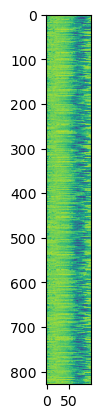

In [7]:
# STIV test with MQD streamline
test_MQD_pix = StreamlinePixelsSingle[2] # Long streamline from edge of image to just before entrance
STIV_vec_MQD = zeros(length(test_MQD_pix), length(I1images))

for img = 1:length(I1images)
    for coord = 1:length(test_MQD_pix)
        j, i = test_MQD_pix[coord]
        STIV_vec_MQD[coord, img] = I1images[i, j, img]
    end
end

plt.imshow(STIV_vec_MQD)
plt.gcf()
